In [2]:
# パッケージ読み込み

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from PIL import Image
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso

In [3]:
# テスト、訓練データ作成（検証データは今回なし）

"""
答えのないデータが別途用意されていることが多い
"""

"""
一般にXは説明変数, yは目的変数を指す
trainは訓練、testはテストデータの意味
大文字は多次元配列、小文字は1次元配列やスカラを意味するケースが多い
"""
X_train, X_test, y_train, y_test = train_test_split(
    fetch_california_housing().data,  # 説明変数の2次元配列(20640, 8)
    fetch_california_housing().target, # 目的変数の1次元配列(20640,)
    random_state=12
)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

FEATURE_COLS = fetch_california_housing().feature_names

(15480, 8) (5160, 8) (15480,) (5160,)


In [8]:
# 推測結果を表示する関数
def report_results(name, y, y_hat):
    return pd.DataFrame({name: {
        "MAE": mean_absolute_error(y, y_hat),
        "MSE": mean_squared_error(y, y_hat),
        "RMSE": np.sqrt(mean_squared_error(y, y_hat)),
        "R2": r2_score(y, y_hat),
    }})

In [9]:
# 何も考えずに線形回帰する

"""
回帰するための関数は用意されている。  
"""

# 線形回帰
lr1 = LinearRegression() # 回帰モデル
lr1.fit(X_train, y_train) # 訓練

# テストデータで検証
predicts1 = lr1.predict(X_test) # 未知データに対してテスト
result1 = report_results("model1", y_test, predicts1) 
print(result1)

        model1
MAE   0.533259
MSE   0.528709
R2    0.606009
RMSE  0.727124


In [12]:
# 標準化を行った後に線形回帰

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("変換前", X_train[0])
print("変換後", X_train_scaled[0]) # -1 ~ 1に補正される


lr2 = LinearRegression()
lr2.fit(X_train_scaled, y_train)

predicts2 = lr2.predict(X_test_scaled)
result2 = report_results("model2", y_test, predicts2)
print(result2)

変換前 [ 2.25620000e+00  3.90000000e+01  5.00744879e+00  1.11173184e+00
  1.88800000e+03  3.51582868e+00  3.77700000e+01 -1.22200000e+02]
変換後 [-0.85172949  0.82022879 -0.1639318   0.02539618  0.43147938  0.0336272
  0.99888522 -1.31108613]
        model2
MAE   0.533259
MSE   0.528709
R2    0.606009
RMSE  0.727124


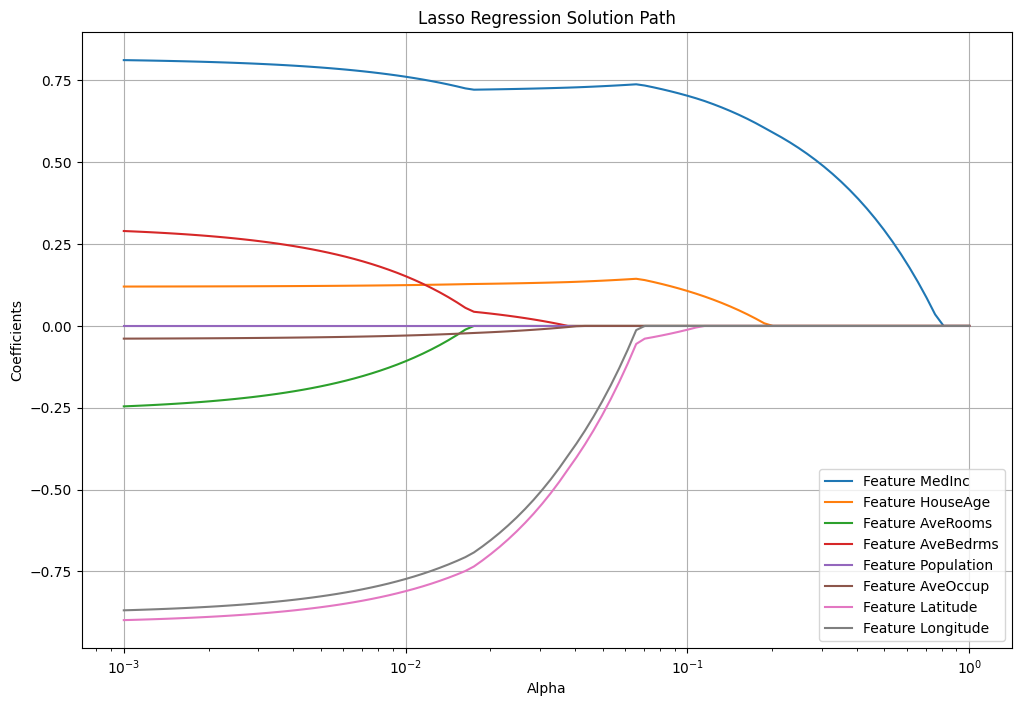

['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']
        model3
MAE   0.533288
MSE   0.528741
R2    0.605985
RMSE  0.727146


In [7]:
# 変数選択を行う

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lasso = Lasso(alpha=0.1)  # alphaは正則化パラメータ（L1正則化の強度）を調整するハイパーパラメータです
coefs = []
alphas = np.logspace(-3, 0, 100)  # alphaの値を対数スケールで設定

# 各alphaでLasso回帰を実行し、係数を取得
for alpha in alphas:
    lasso.set_params(alpha=alpha)
    lasso.fit(X_train_scaled, y_train)
    coefs.append(lasso.coef_)

# 解パス図を描画
plt.figure(figsize=(12, 8))
plt.plot(alphas, coefs)
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('Coefficients')
plt.title('Lasso Regression Solution Path')
plt.legend([f'Feature {i}' for i in FEATURE_COLS])
plt.grid(True)
plt.show()

# 'Population'を取り除いて線形回帰
print(FEATURE_COLS)
X_train_trimmed = X_train[:, [0, 1,2,3,5,6,7]]
X_test_trimmed = X_test[:, [0, 1,2,3,5,6,7]]

lr3 = LinearRegression()
lr3.fit(X_train_trimmed, y_train)

predicts3 = lr3.predict(X_test_trimmed)
result3 = report_results("model3", y_test, predicts3)
print(result3)

解パス図（上）はLasso回帰によって出力される図で、変量選択に役立つ。  
右に0になるほど重要な変量で、早期に0になるものはさほど重要でない  

実際にPopluationを抜いても結果は変わらない

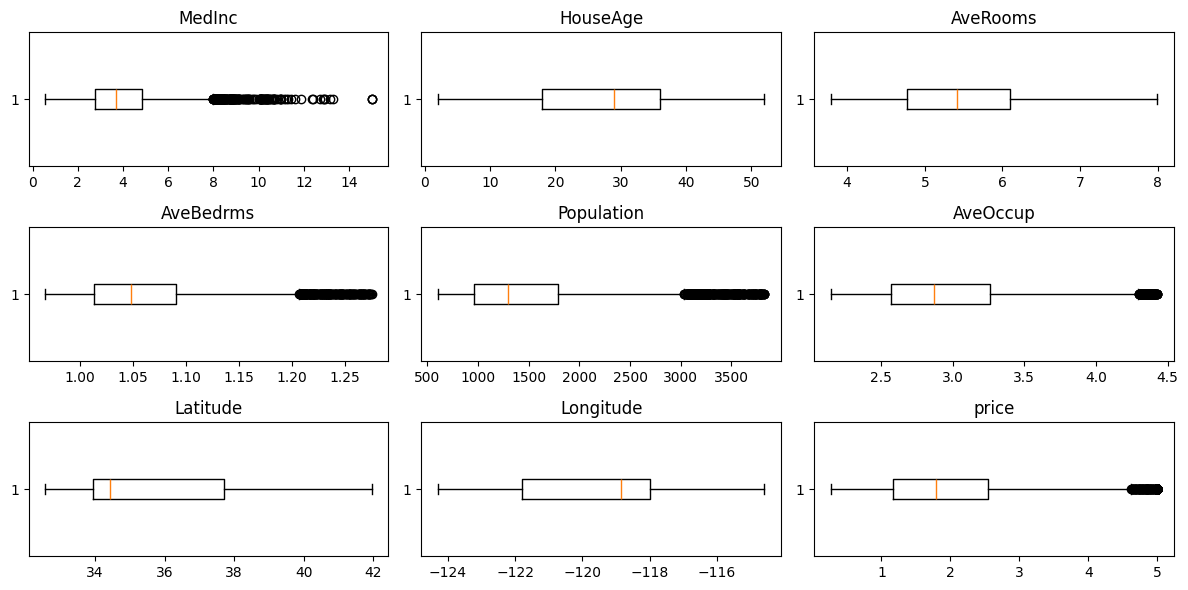

(8664, 9)
        model4
MAE   0.531805
MSE   0.674566
R2    0.497317
RMSE  0.821320


In [13]:
# 外れ値を除外した学習データを作る
# DF1

df1 = pd.DataFrame(X_train)
df1.columns = fetch_california_housing().feature_names
df1["price"] = y_train

# 一律カット
for col in ["AveRooms", "AveBedrms", "Population", "AveOccup"]:
    df1 = df1.loc[
        (df1[col].quantile(0.1) < df1[col])
        & (df1[col] < df1[col].quantile(0.965))
    ]


# 箱ひげ図の確認
cols = df1.columns
fig, ax = plt.subplots(len(cols)//3, 3, figsize=(12,6))
ax = ax.flatten()
for i, col in enumerate(cols):
    ax[i].boxplot(df1[col],vert=False)
    ax[i].set_title(col)
plt.tight_layout()
plt.show()

#display(df1.describe())
print(df1.shape)

# このデータを使って線形回帰
lr4 = LinearRegression()
lr4.fit(df1[FEATURE_COLS].values, df1["price"].values)

predicts4 = lr4.predict(X_test)
result4 = report_results("model4", y_test, predicts4)
print(result4)

        model5
MAE   0.523335
MSE   0.516375
R2    0.615200
RMSE  0.718592


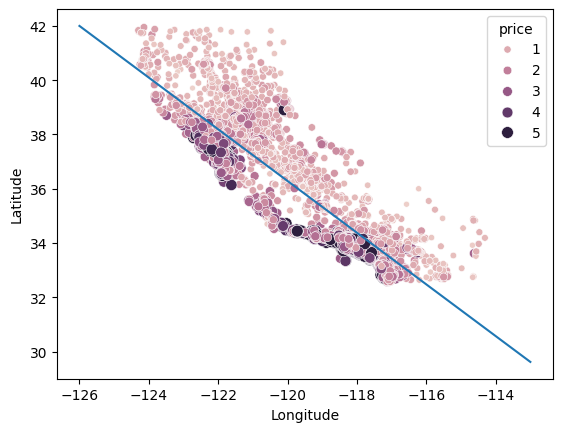

In [10]:
# 東海岸を分けたい


df2 = pd.DataFrame(X_train)
df2.columns = fetch_california_housing().feature_names
df2["price"] = y_train

f,a = plt.subplots()
sns.scatterplot(data=df2, y="Latitude", x="Longitude", size="price", hue="price")

# 適当に線を引いてみた
x = np.array(range(-126, -112))
y = x *-1/1.05 - 78
a.plot(x, y)

# 海岸側か判定する
def is_east(long, lat):
    if lat > long * -1/1.05 - 78:
        return 1
    return 0

# 絡む追加
_d = []
for row in X_train:
    _d.append([is_east(row[7], row[6])])
X_train_append = np.hstack((X_train, _d))
_d = []
for row in X_test:
    _d.append([is_east(row[7], row[6])])
X_test_append = np.hstack((X_test, _d))

# 線形回帰
lr5 = LinearRegression()
lr5.fit(X_train_append, df2["price"].values)

predicts5 = lr5.predict(X_test_append)
result5 = report_results("model5", y_test, predicts5)
print(result5)

In [14]:
# 給与レンジから高/低所得層フラグを追加してみる

#print(FEATURE_COLS)

train_higher = np.where(X_train[: ,0] > 5.3, 1, 0).reshape(-1, 1) # 値はEDAから取得
test_higher = np.where(X_test[: ,0] > 5.3, 1, 0).reshape(-1, 1)
train_lower = np.where(X_train[: ,0] < 2.2, 1, 0).reshape(-1, 1)
test_lower = np.where(X_test[: ,0] < 2.2, 1, 0).reshape(-1, 1)

X_train_incomerenge = np.hstack((X_train, train_higher, train_lower))
X_test_incomerenge = np.hstack((X_test, test_higher, test_lower))

# 線形回帰
lr6 = LinearRegression()
lr6.fit(X_train_incomerenge, y_train)

predicts6 = lr6.predict(X_test_incomerenge)
result6 = report_results("model6", y_test, predicts6)
print(result6)

        model6
MAE   0.530828
MSE   0.523828
R2    0.609647
RMSE  0.723759


In [74]:
# 別の回帰モデルを使ってみる

from xgboost import XGBRegressor

model7 = XGBRegressor()
model7.fit(X_train, y_train)
predicts7 = model7.predict(X_test)

result7 = report_results("model7", y_test, predicts7)
print(result7)

        model7
MAE   0.310305
MSE   0.222446
R2    0.834235
RMSE  0.471641


In [75]:
# XGBoostをパラメータチューニングする
# 最適なパラメータを総当りでチェックする
# 激重です

from sklearn.model_selection import GridSearchCV
params = {
          'learning_rate': [0.05, 0.1], 
          'max_depth': [3, 5], 
          'subsample': [0.9, 0.95], 
         }

cv = GridSearchCV(XGBRegressor(), params, cv = 5,  n_jobs =1)
cv.fit(X_train, y_train)

print(cv.best_params_)
model8 = XGBRegressor(**cv.best_params_)
model8.fit(X_train, y_train)
predicts8 = model8.predict(X_test)
result8 = report_results("model8", y_test, predicts8)
print(result8)

{'learning_rate': 0.1, 'max_depth': 5, 'subsample': 0.9}
        model8
MAE   0.325797
MSE   0.231794
R2    0.827269
RMSE  0.481449


In [76]:
# XGBoostに対して、model5,6の前処理を取り入れる

_train_is_east = []
for row in X_train:
    _train_is_east.append([is_east(row[7], row[6])])
_test_is_east = []
for row in X_test:
    _test_is_east.append([is_east(row[7], row[6])])

#print((X_train.shape, train_higher.shape, train_lower.shape, np.array(_train_is_east).shape))
#print((X_test.shape, test_higher.shape, test_lower.shape, np.array(_test_is_east).shape))

X_train9 = np.hstack((X_train, train_higher, train_lower, _train_is_east))
X_test9 = np.hstack((X_test, test_higher, test_lower, _test_is_east))

model9 = XGBRegressor()
model9.fit(X_train9, y_train)
predicts9 = model9.predict(X_test9)

result9 = report_results("model9", y_test, predicts9)
print(result9)

        model9
MAE   0.306533
MSE   0.217858
R2    0.837654
RMSE  0.466753


## それぞれの結果を見てみる


,model1,model2,model3,model4,model5,model6,model7,model8,model9
MAE,0.533259,0.533259,0.533288,0.531805,0.523335,0.530828,0.310305,0.325797,0.306533
MSE,0.528709,0.528709,0.528741,0.674566,0.516375,0.523828,0.222446,0.231794,0.217858
R2,0.606009,0.606009,0.605985,0.497317,0.615200,0.609647,0.834235,0.827269,0.837654
RMSE,0.727124,0.727124,0.727146,0.821320,0.718592,0.723759,0.471641,0.481449,0.466753


<Axes: >

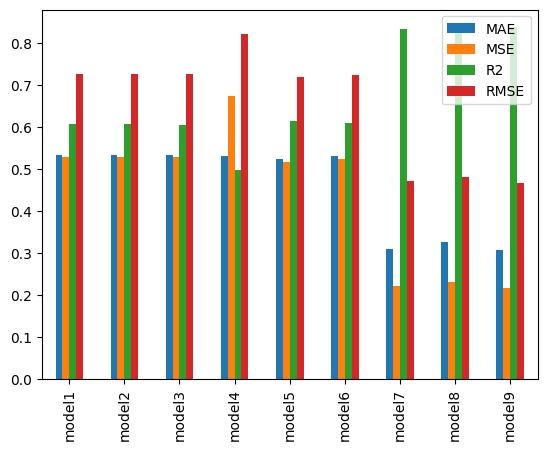

In [84]:
all_Result = pd.concat([result1, result2, result3, result4, result5, result6, result7, result8, result9], axis=1)
display(all_Result)
all_Result.T.plot.bar()

標準化（model2）はmodel1と変化ないので、モデル内で勝手にやってくれている模様

線形回帰の中ではmodel5,6が良いスコアを示すがあまり変わらない。

Boosting手法であるXGBoostはかなり良い評価を示し、model5,6と同じ前処理を行ったmodel9が最も性能が良いと言える。